In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
%matplotlib inline

cp.cuda.Device(0).use()

<CUDA Device 0>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
ntheta = 180  # number of angles (rotations)
n = 512
pn = 32  # tomography chunk size for GPU processing
ptheta = 180  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 33.35  # [keV] xray energy
focusToDetectorDistance = 1.28
ndist = 4
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0

# ndist = 12
# sx0 = 3.7e-4
# z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
# z1 = np.concatenate((z1,z1+1e-4,z1+5e-4))

z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2
# norm_magnifications[:] = 1

## Read data

In [3]:
data = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref = np.zeros([1,n,n],dtype='float32')

for k in range(ndist):
    data[k] = dxchange.read_tiff(f'data/modeling/data_chip_{n}_{k}.tiff')[:ntheta]
ref[:] = dxchange.read_tiff(f'data/modeling/ref_chip_{n}_0.tiff')
shifts = np.load('shifts.npy')[:ndist,:ntheta]

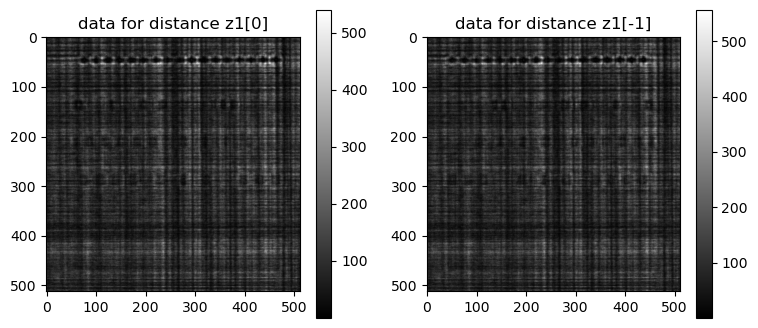

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(data[0,0],cmap='gray')
axs[0].set_title('data for distance z1[0]')
fig.colorbar(im)
im=axs[1].imshow(data[0,-1],cmap='gray')
axs[1].set_title('data for distance z1[-1]')
fig.colorbar(im)


## Create a solver class for holography

In [5]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications,distances2)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Adjoint test

In [6]:
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
print(arr1.shape,prb1.shape,shifts_ref.shape)
arr2 = pslv.fwd_holo_batch(arr1,prb1, shifts_ref)
arr3 = pslv.adj_holo_batch(arr2,prb1, shifts_ref)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, shifts_ref)


print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(180, 1024, 1024) (1, 512, 512) (4, 180, 2)


(1.1563901e+17+1257141500j)
(1.1563879e+17-50284.92j)
(1.1563851e+17+183500800j)


## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2 + \||\mathcal{G}_{d_0}q|-\sqrt{\text{I}_r}\|_2^2\to \text{min}_{\psi_i,q}$ 

In [7]:
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma


def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1,vis_step=1):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f += cp.linalg.norm(cp.abs(fprb)-cp.sqrt(data_ref))**2        
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = 1
    gammaprb = 1
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts)          
            grad = pslv.adj_holo(fpsi-cp.sqrt(data)*cp.exp(1j*(cp.angle(fpsi))), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2
            # d = -grad    
            # Dai-Yuan direction
            if i == 0:
                d = -grad
            else:
                d = -grad+cp.linalg.norm(grad)**2 / \
                    ((cp.sum(cp.conj(d)*(grad-grad0))))*d
            grad0 = grad
            # line search
            fd = pslv.fwd_holo(d, prb,shifts)     
            gammapsi = line_search(minf, 1, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d#*cp.exp(-1j*0.3)        
            # psi*=cp.exp(-1j*cp.max(cp.angle(psi)))
            # print(cp.mean(cp.angle(psi))      )
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo(psi*0+1,prb,shifts*0)
            
            gradprb = pslv.adj_holo_prb(fprb-cp.sqrt(data)*cp.exp(1j*cp.angle(fprb)),psi,shifts)/cp.max(cp.abs(psi))**2/pslv.ntheta#/ndist**2
            gradprb += pslv0.adj_holo_prb(fprb0-cp.sqrt(data_ref)*cp.exp(1j*cp.angle(fprb0)),psi*0+1,shifts*0)
            gradprb*=0.5
            dprb = -gradprb
            # gradprb0 = gradprb
            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts)
            fdprb0 = pslv0.fwd_holo(psi*0+1, dprb,shifts*0)
            
            gammaprb = line_search(minf, 1, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            # fprb0 = pslv0.fwd_holo(psi*0+1,prb,shifts*0)            
            err=minf(fprb,0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')  
    
        if i%vis_step==0:  
            fig, axs = plt.subplots(2, 2, figsize=(7, 7))
            im=axs[0,0].imshow(np.abs(psi[0].get()),cmap='gray')
            axs[0,0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[0,1].imshow(np.angle(psi[0].get()),cmap='gray')
            axs[0,1].set_title('reconstructed phase')
            fig.colorbar(im)
            im=axs[1,0].imshow(np.abs(prb[0].get()),cmap='gray')
            axs[1,0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1,1].imshow(np.angle(prb[0].get()),cmap='gray')
            axs[1,1].set_title('reconstructed phase')
            fig.colorbar(im)
            
            plt.show()
        
    return psi,prb

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,upd_psi=True,upd_prb=False,step=1,vis_step=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                

    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts,upd_psi, upd_prb,step,vis_step)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb

rec = np.ones([1,2*n,2*n],dtype='complex64')
rec_prb = np.ones([1,n,n],dtype='complex64')        
data_ref = ref[:1,np.newaxis]
shifts_ref = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])[:1,:1]*0

print(f'{data_ref.shape=},{rec.shape=},{rec_prb.shape=},{data_ref.shape=},{shifts_ref.shape=}')

# pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distances2[:1]) 
# _,rec_prb = cg_holo_batch(pslv, data_ref, rec, rec_prb, 256, shifts_ref, False,True,32,10000)

# fig, axs = plt.subplots(1, 2, figsize=(15, 8))
# im=axs[0].imshow(np.abs(rec_prb[0]),cmap='gray')
# axs[0].set_title('reconstructed amplitude')
# fig.colorbar(im)
# im=axs[1].imshow(np.angle(rec_prb[0]),cmap='gray',vmin=-1,vmax=1)
# axs[1].set_title('reconstructed phase')
# fig.colorbar(im)


data_ref.shape=(1, 1, 512, 512),rec.shape=(1, 1024, 1024),rec_prb.shape=(1, 512, 512),data_ref.shape=(1, 1, 512, 512),shifts_ref.shape=(1, 1, 2)


0) gammapsi=0.5 gammaprb=1, err=2.00527e+05


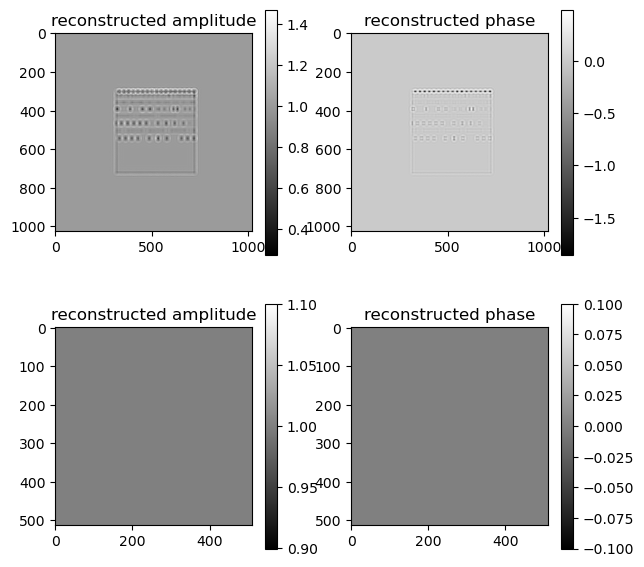

32) gammapsi=0.5 gammaprb=1, err=5.72580e+04


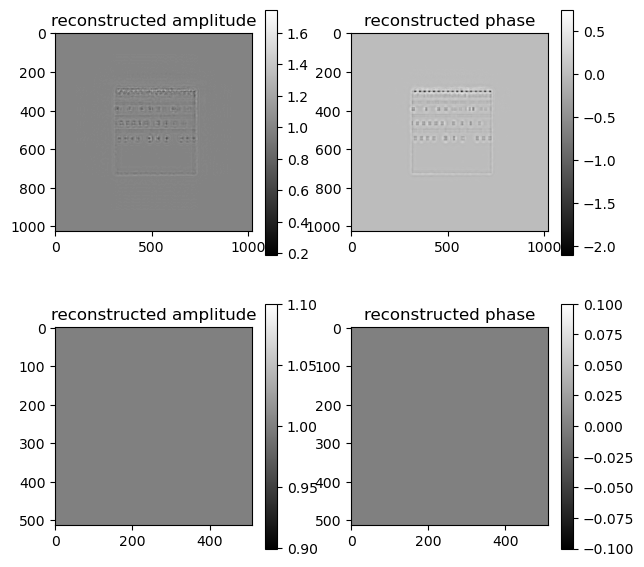

64) gammapsi=0.5 gammaprb=1, err=5.35249e+04


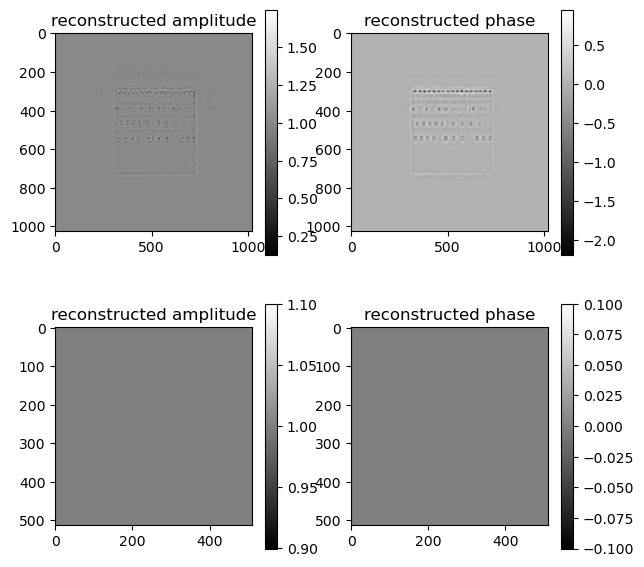

96) gammapsi=0.5 gammaprb=1, err=5.15449e+04


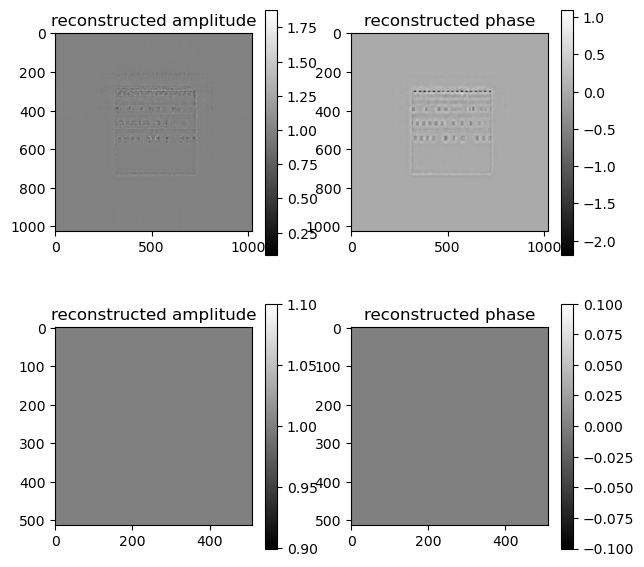

128) gammapsi=0.5 gammaprb=1, err=5.03472e+04


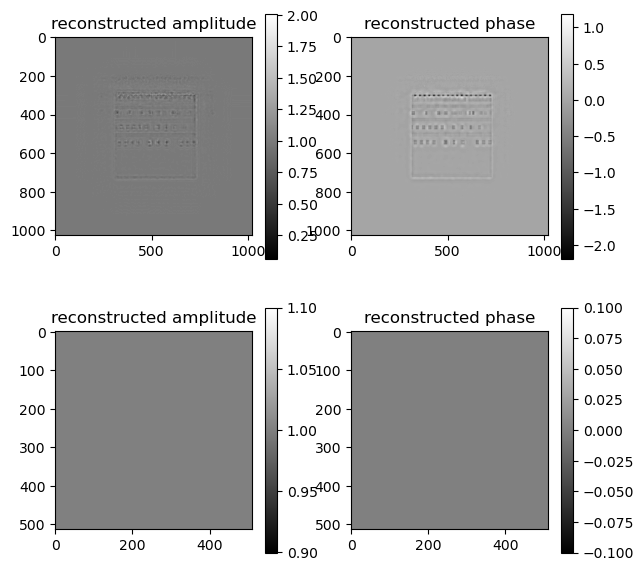

In [8]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distances2) 
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distances2[:1]) 

shifts_rec = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])
rec = np.ones([ntheta,2*n,2*n],dtype='complex64')

rec_prb[:] = 1
rec,rec_prb = cg_holo_batch(pslv, pslv0, data/(data_ref+1e-7), data_ref*0+1, rec, rec_prb, 257, shifts_rec, True,False,32,32)

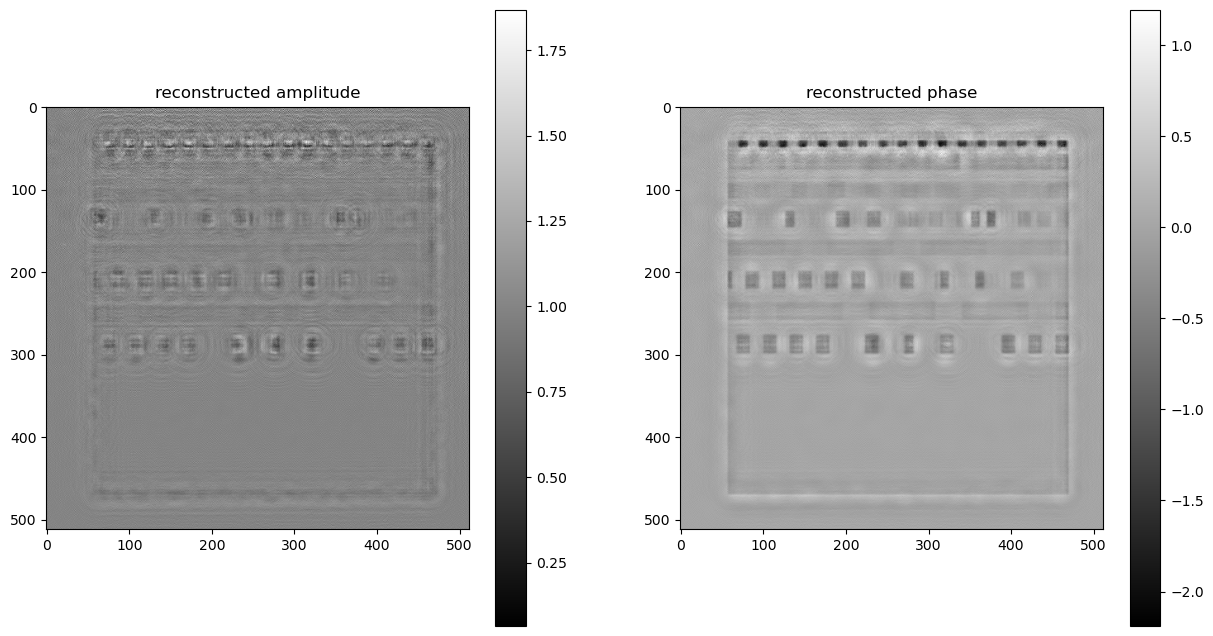

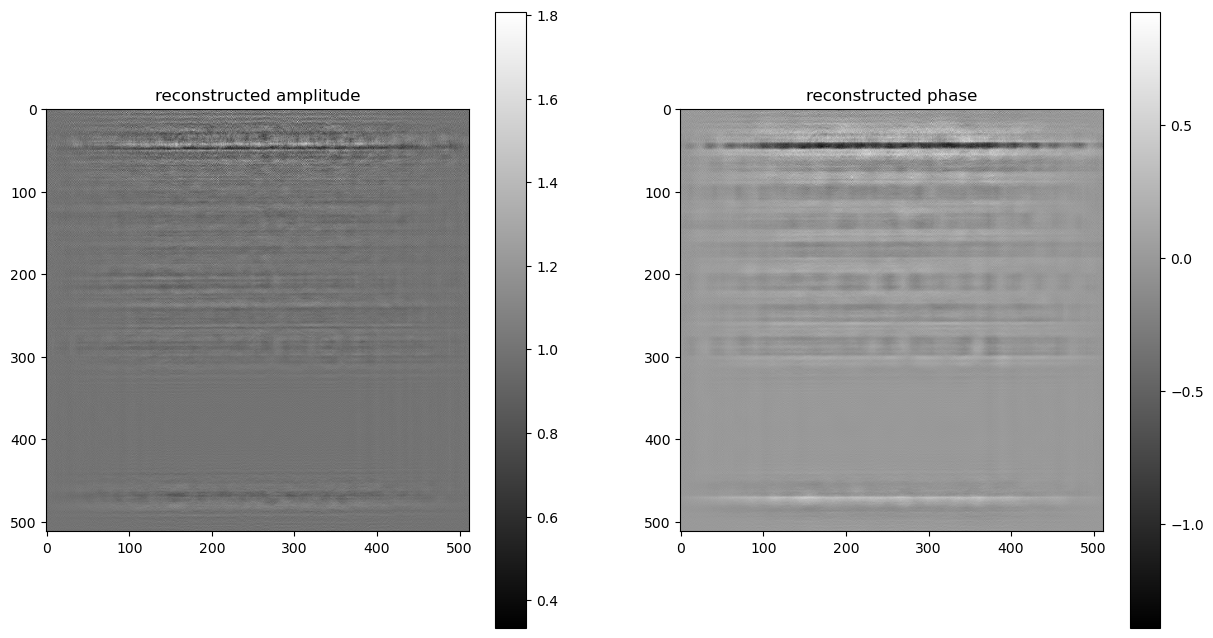

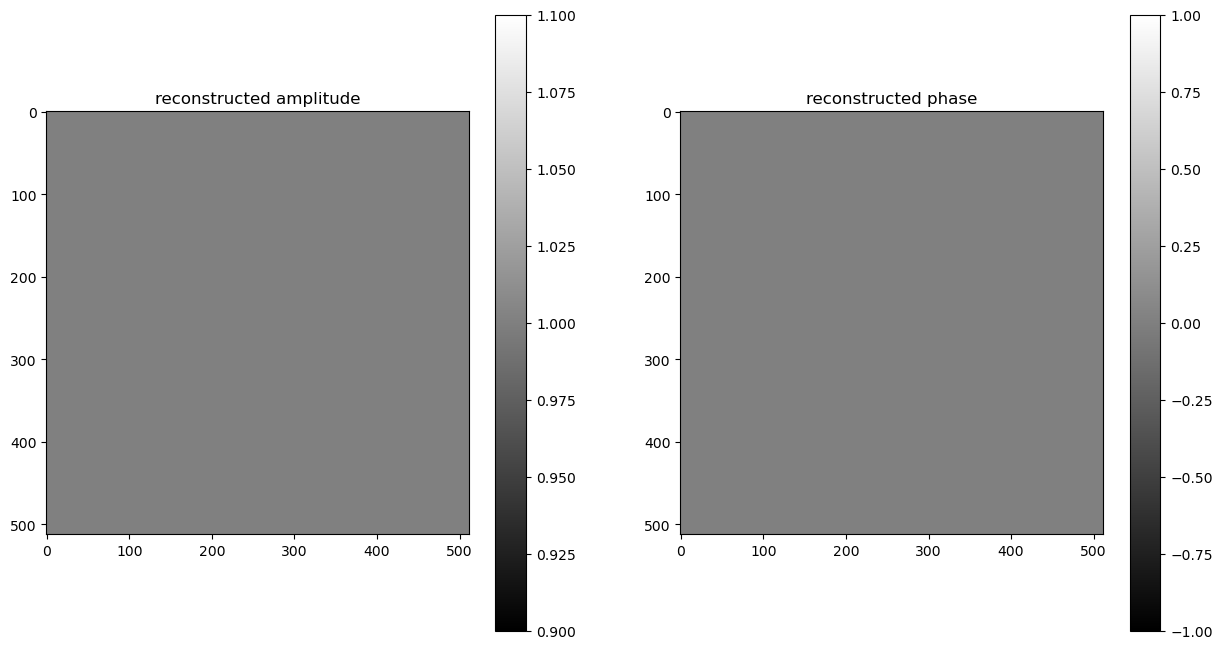

In [9]:
dxchange.write_tiff(np.abs(rec),f'/data/vnikitin/holo//psirec_chip_reg256_abs{n}_{ntheta}_{ndist}',overwrite=True)
dxchange.write_tiff(np.angle(rec),f'/data/vnikitin/holo/psirec_chip_reg256_angle{n}_{ntheta}_{ndist}',overwrite=True)

dxchange.write_tiff(np.abs(rec_prb),f'/data/vnikitin/holo/prbrec_chip_reg256_abs{n}_{ntheta}_{ndist}',overwrite=True)
dxchange.write_tiff(np.angle(rec_prb),f'/data/vnikitin/holo/prbrec_chip_reg256_angle{n}_{ntheta}_{ndist}',overwrite=True)



fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[ntheta//8,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[ntheta//8,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec_prb[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb[0]),cmap='gray',vmin=-1,vmax=1)
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
np.save('/data/tmp/rec',rec)


# Convert the recovered transmittance function to the complex refractive index: $-\frac{i \lambda}{2\pi} \log(\psi)$  

In [10]:
projrec = pslv.logtomo(rec)

# Show sinogram

(180, 1024, 1024)


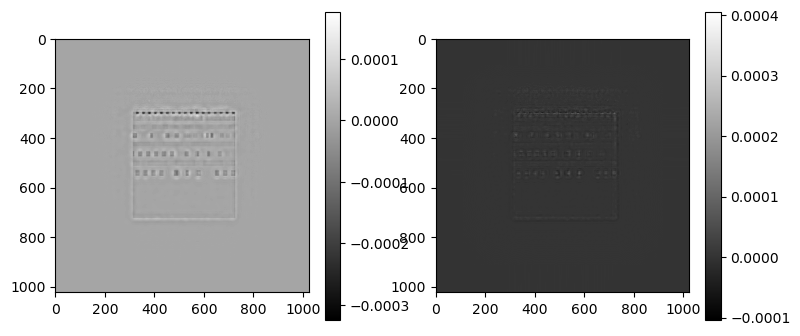

In [11]:
print(projrec.shape)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(projrec[0]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.imag(projrec[0]),cmap='gray')
fig.colorbar(im)

## Step 1. $\sum_i\sum_j||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi_i,q} $
$i$ - index for angles\
$j$ - index for planes \
$\psi$ - sample at plane 0 \
$q$ - probe at plane 0\
$M_j$ - object normalized (de-)magnification for the plane $j$ \
$S_r$ - shift for distance r (x and y), shifts between angles + alignment shifts \
$\mathcal{G}_d$ - Fresnel transform for distance $d$

## Step 2.  $\sum_i\|\mathcal{R}_i u-\frac{\text{i} \lambda}{2\pi} \log(\psi_i)\|^2_2\to\text{min}_u$  
$\mathcal{R}_i$ - Radon transform wrt angle i\

$u = 1-\delta_0+\beta \to  u = \delta+\beta$


In [12]:
pslv = []
pslv0 = []

tslv = holotomo.SolverTomo(theta, ntheta, 2*n, 2*n, pn, 2*center)
init = np.zeros([2*n,2*n,2*n],dtype='complex64')
piter = 64
urec = tslv.cg_tomo_batch(projrec,init,piter)

0) gamma=1, err=1.5161327610258013e-05
1) gamma=1, err=1.314558267040411e-05
2) gamma=1, err=1.2537358088593464e-05
3) gamma=1, err=1.1763027032429818e-05
4) gamma=1, err=1.1309268302284181e-05
5) gamma=1, err=1.0924749403784517e-05
6) gamma=1, err=1.0219824616797268e-05
7) gamma=1, err=8.95688481250545e-06
8) gamma=1, err=7.965572876855731e-06
9) gamma=1, err=7.2669272412895225e-06
10) gamma=1, err=5.65482378078741e-06
11) gamma=1, err=3.968526016251417e-06
12) gamma=1, err=3.3305168471997604e-06
13) gamma=1, err=3.0566279747290537e-06
14) gamma=1, err=2.277479779877467e-06
15) gamma=1, err=2.0361303540994413e-06
16) gamma=1, err=1.2887317097920459e-06
17) gamma=1, err=1.1832078143925173e-06
18) gamma=1, err=8.278726681965054e-07
19) gamma=1, err=7.104430324034183e-07
20) gamma=1, err=6.669062031505746e-07
21) gamma=1, err=6.216918677637295e-07
22) gamma=1, err=5.430864007394121e-07
23) gamma=1, err=5.032717353969929e-07
24) gamma=1, err=4.575246350668749e-07
25) gamma=1, err=4.066478

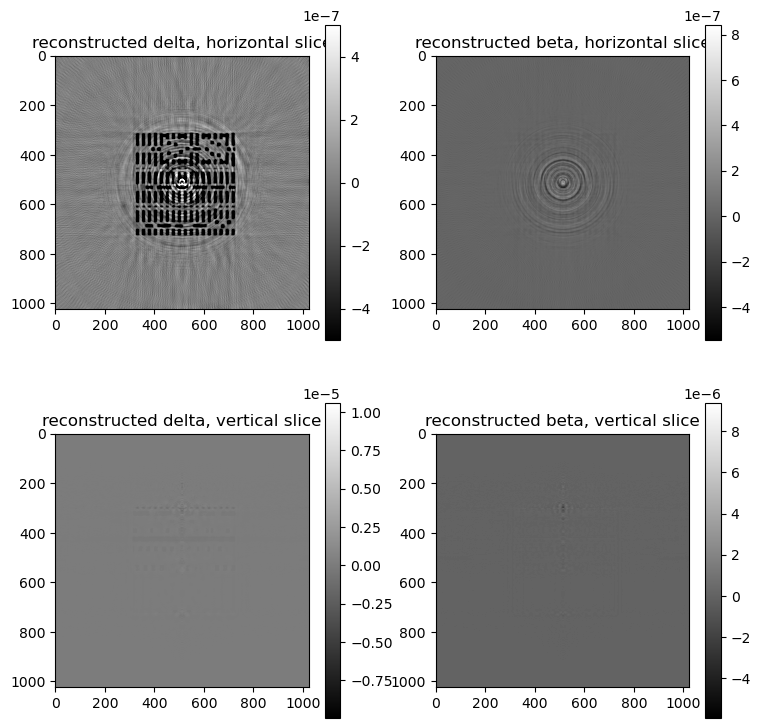

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(urec[301].real,cmap='gray',vmin=-0.5e-6,vmax=0.5e-6)
axs[0,0].set_title('reconstructed delta, horizontal slice')
fig.colorbar(im)
im=axs[0,1].imshow(urec[133].imag,cmap='gray')
axs[0,1].set_title('reconstructed beta, horizontal slice')
fig.colorbar(im)
im=axs[1,0].imshow(urec[:,n].real,cmap='gray')
axs[1,0].set_title('reconstructed delta, vertical slice')
fig.colorbar(im)
im=axs[1,1].imshow(urec[:,n].imag,cmap='gray')
axs[1,1].set_title('reconstructed beta, vertical slice')
fig.colorbar(im)

In [14]:

dxchange.write_tiff(urec.real,f'/data/vnikitin/holo/urec_chip_reg256_re{n}_{ntheta}_{ndist}',overwrite=True)
dxchange.write_tiff(urec.imag,f'/data/vnikitin/holo/urec_chip_reg256_im{n}_{ntheta}_{ndist}',overwrite=True)

